In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import git
import sys
import os
import time
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from collections import defaultdict, OrderedDict

from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
from argoverse.map_representation.map_api import ArgoverseMap

repo = git.Repo('.', search_parent_directories=True)
BASE_DIR = repo.working_tree_dir
sys.path.append(BASE_DIR)

import model.datasets.argoverse.dataset as dataset
import model.datasets.argoverse.dataset_utils as dataset_utils 
import model.datasets.argoverse.map_functions as map_functions

# Set root_dir to the correct path to your dataset folder

split_name = "train"
root_dir = os.path.join(BASE_DIR,f'data/datasets/argoverse/motion-forecasting/{split_name}/data/')

avm = ArgoverseMap()
afl = ArgoverseForecastingLoader(root_dir)

obs_len = 20 # steps
pred_len = 30 # steps
freq = 10 # Hz ("steps/s")
obs_origin = 20 

print('Total number of sequences:',len(afl))

Total number of sequences: 205942


In [3]:
files, num_files = dataset_utils.load_list_from_folder(root_dir)

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    file_id = int(os.path.normpath(file_name).split('/')[-1].split('.')[0])
    file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

Num files:  205942


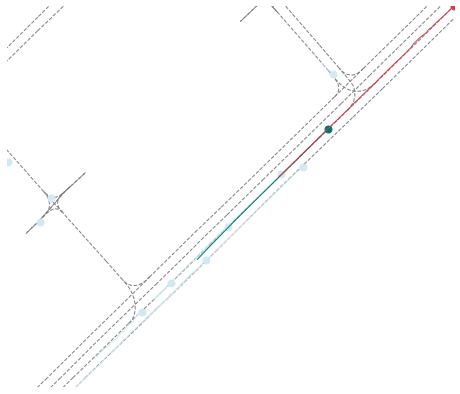

Viz seq:  6.387105464935303


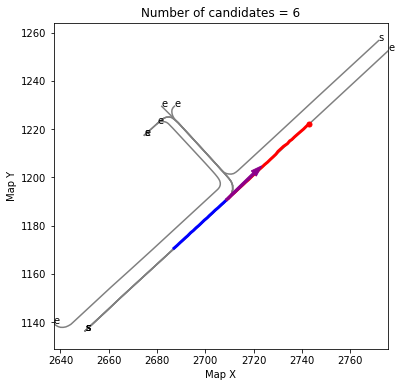

Candidate centerlines using Argoverse forecasting baseline:  0.3144247531890869


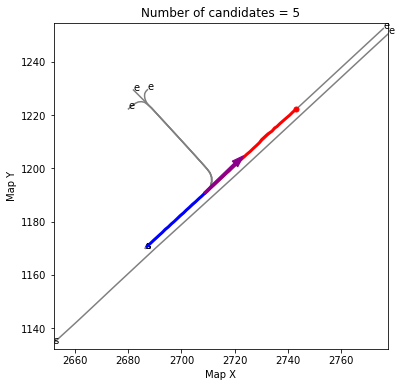

Candidate centerlines using Argoverse Map API:  0.24707412719726562


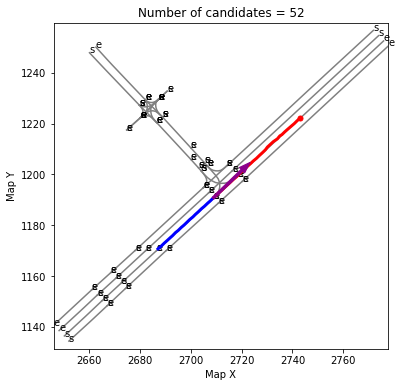

Candidate centerlines computing lanes around:  0.9170770645141602


/home/denso/anaconda3/envs/carlos_vsr_mapfe4mp/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


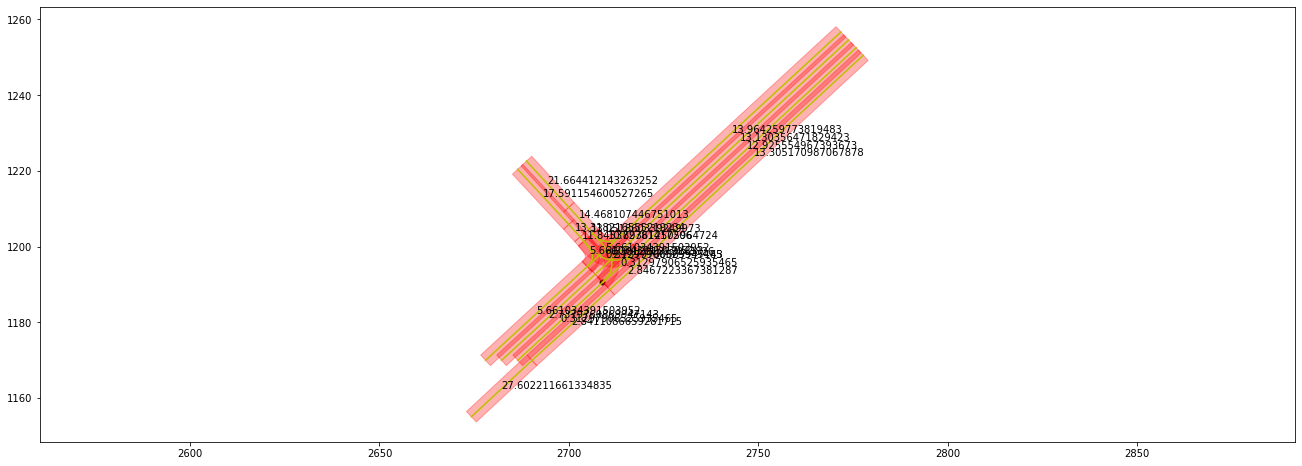

Nearest centerline:  0.19106125831604004


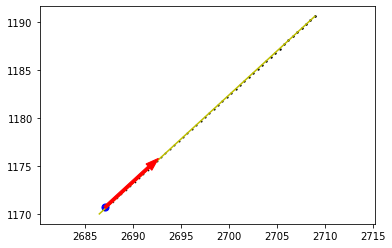

Get lane direction:  0.3759458065032959


In [14]:
split_name = "train"
seq_id = 1
viz = True

RAW_DATA_FORMAT = {
    "TIMESTAMP": 0,
    "TRACK_ID": 1,
    "OBJECT_TYPE": 2,
    "X": 3,
    "Y": 4,
    "CITY_NAME": 5,
}

root_dir = os.path.join(BASE_DIR,f'data/datasets/argoverse/motion-forecasting/{split_name}/data/')
seq_path = f"{root_dir}/{seq_id}.csv"

# Visualize sequence

start = time.time()
viz_sequence(afl.get(seq_path).seq_df, show=viz)
end = time.time()
print("Viz seq: ", end-start)

# Visualize centerlines

df = pd.read_csv(seq_path, dtype={"TIMESTAMP": str})
agent_track = df[df["OBJECT_TYPE"] == "AGENT"].values
agent_xy = agent_track[:,[RAW_DATA_FORMAT["X"],RAW_DATA_FORMAT["Y"]]].astype("float")
origin_pos = agent_xy[obs_len-1,:]
city_name = agent_track[0, RAW_DATA_FORMAT["CITY_NAME"]]
map_features_utils_instance = map_functions.MapFeaturesUtils()

## Using Argoverse competition baseline

start = time.time()

map_features, map_feature_helpers = map_features_utils_instance.compute_map_features(
        agent_track,
        seq_id,
        split_name,
        obs_len,
        obs_len + pred_len,
        RAW_DATA_FORMAT,
        "test", # mode (if test, return K plausible candidates. Otherwise, return best possible candidate)
        avm,
        viz=viz,
        #max_candidates=2
        algorithm="competition" # competition, map_api, get_around  
    )

end = time.time()
print("Candidate centerlines using Argoverse forecasting baseline: ", end-start)

## Using Map API

start = time.time()

map_features, map_feature_helpers = map_features_utils_instance.compute_map_features(
        agent_track,
        seq_id,
        split_name,
        obs_len,
        obs_len + pred_len,
        RAW_DATA_FORMAT,
        "test", # mode (if test, return K plausible candidates. Otherwise, return best possible candidate)
        avm,
        viz=viz,
        #max_candidates=2
        algorithm="map_api" # competition, map_api, get_around  
    )
map_features_ = map_features
map_feature_helpers_ = map_feature_helpers

end = time.time()
print("Candidate centerlines using Argoverse Map API: ", end-start)

## Computing lanes around center, given dist_around

start = time.time()

map_features, map_feature_helpers = map_features_utils_instance.compute_map_features(
        agent_track,
        seq_id,
        split_name,
        obs_len,
        obs_len + pred_len,
        RAW_DATA_FORMAT,
        "test", # mode (if test, return K plausible candidates. Otherwise, return best possible candidate)
        avm,
        viz=viz,
        #max_candidates=2
        algorithm="get_around" # competition, map_api, get_around  
    )

end = time.time()
print("Candidate centerlines computing lanes around: ", end-start)

# Visualize nearest centerline

start = time.time()
nearest_centerline = avm.get_nearest_centerline(np.array(origin_pos), city_name, visualize=viz)
end = time.time()
print("Nearest centerline: ", end-start)

# Visualize lane direction in the last observation frame

agent_traj = afl.get(seq_path).agent_traj
start = time.time()
lane_direction = avm.get_lane_direction(agent_traj[0], city_name, visualize=viz)
end = time.time()
print("Get lane direction: ", end-start)